# This notebook is for making and saving data trying to test the Kenicutt-Schmidt law in the simulations

In [ ]:
################################
# Script for testing the 
# Kennicutt-Schmidt Law

# run for each sim
################################

# imports
import yt
import numpy as np
import matplotlib.pyplot as plt
from yt.data_objects.particle_filters import add_particle_filter
import statsmodels.api as sm


# make the filter for formed stars
def formed_star(pfilter, data):
    filter = data['all', 'creation_time'] >0
    return filter

# make the filter for new/young stars
def new_stars(pfilter, data):
    age = data.ds.current_time - data[pfilter.filtered_type, "creation_time"]
    filter = np.logical_and(age.in_units("Myr") <= 50, age >= 0)
    return filter

# define the power law
def power_law(x, A, b):
    return A*x**b

# add the filters
add_particle_filter("formed_star", function=formed_star, filtered_type='all', requires=["creation_time"])

add_particle_filter("new_stars", function=new_stars, filtered_type="formed_star", requires=["creation_time"])

# create master arrays
SFR_density_array = np.empty(1)
gas_density_array = np.empty(1)
times_for_plot = np.empty(1)
times_for_b = np.empty(1)
A_array = np.empty(1)
b_array = np.empty(1)

# need this data for each snapshot of the simulation, so need to make a timeseries
ts = yt.load("/mnt/research/galaxies-REU/sims/claire_isogal_sims/newCGM_h2sf/DD????/DD????")

for ds in ts.piter():
    
    #making sure there are particles to run it
    if ds.particles_exist == False:
        continue
    
    # add the new stars filter and create cylinder
    ds.add_particle_filter("new_stars")
    myzcylinder = ds.disk([0.5,0.5,0.5], [0,0,1], (206,'kpc'), (50,'kpc'))

    # make projection plots and collapse them into arrays of data
    p_stars = yt.ProjectionPlot(ds, 'z', ('deposit', 'new_stars_density'), data_source=myzcylinder, center=[0.5,0.5,0.5])

    star_density_data = np.array(p_stars.frb['new_stars_density'])

    p_dens = yt.ProjectionPlot(ds, 'z', ('gas', 'density'), data_source=myzcylinder, center=[0.5,0.5,0.5])

    density_data = np.array(p_dens.frb['density'])
    
    
    # get the SFR density and gas density into correct units
    star_density_pc = (star_density_data*10000*1.05e33)/1.989e33 #converting from g/cm^2 to Msun/pc^2
    SFR_density = star_density_pc/50e6
    
    density_pc = density_data*10000*1.05e33 #converting from g/cm^2 to g/pc^2
    
    # mask based on where SFR is
    SFR_dens_gt0 = SFR_density[SFR_density > 0]
    density_where_SFR = density_pc[SFR_density > 0]
    
    if len(SFR_dens_gt0)>2:
        # Log-transform the data
        log_dens = np.log(density_where_SFR)
        log_SFR = np.log(SFR_dens_gt0)

        # Add a constant to the log density (intercept term)
        log_dens = sm.add_constant(log_dens)

        # Fit the model
        model = sm.OLS(log_SFR, log_dens).fit()

        # Extract the parameters
        A = np.exp(model.params[0])
        b = model.params[1]

        # add the current data to master arrays
        SFR_density_array = np.concatenate((SFR_density_array, SFR_dens_gt0))
        gas_density_array = np.concatenate((gas_density_array, density_where_SFR))
        times_for_plot = np.concatenate((times_for_plot,np.full(len(SFR_dens_gt0), ds.current_time.to('Gyr'))))
        times_for_b = np.concatenate((times_for_b, np.array([ds.current_time.to('Gyr')])))
        A_array = np.concatenate((A_array, np.array([A])))
        b_array = np.concatenate((b_array, np.array([b])))
        
    else:
        print('Not enough data points to fit')
        SFR_density_array = np.concatenate((SFR_density_array, SFR_dens_gt0))
        gas_density_array = np.concatenate((gas_density_array, density_where_SFR))
        times_for_plot = np.concatenate((times_for_plot,np.full(len(SFR_dens_gt0), ds.current_time.to('Gyr'))))
        
    
# Save to a text file
# Combine into a 2D array (each row is a pair of corresponding values)
combined_KS_data = np.column_stack((times_for_plot,gas_density_array,SFR_density_array))
combined_params_data = np.column_stack((times_for_b,A_array,b_array))

# Save the combined data to a text file
np.savetxt('newCGM_KS_SFR_and_density_data.txt', combined_KS_data, delimiter=',', 
            header='Times,Gas Density,SFR Density', comments='', fmt='%.6e')

np.savetxt('newCGM_KS_params_data.txt', combined_params_data, delimiter=',', 
            header='Times,A param,b param', comments='', fmt='%.6e')

## This section is looking at the data for KS law

### Loads in the data from saved txt files, and tries to fit the data using the averages of bins

#### Starting by looking at fiducial data. Start by plotting all data grouped by time

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
# load in data
fid_time, fid_gas, fid_SFR = np.loadtxt('./txt_files/fid_KS_SFR_and_density_data.txt', delimiter=',', unpack=True, skiprows=2)
fid_param_time, fid_A, fid_b = np.loadtxt('./txt_files/fid_KS_params_data.txt', delimiter=',', unpack=True, skiprows=1)

In [3]:
# mask data into time groups
fid_gas_lt500Myr = fid_gas[fid_time<=0.5]
fid_SFR_lt500Myr = fid_SFR[fid_time<=0.5]

fid_gas_lt1Gyr = fid_gas[(fid_time>0.5) & (fid_time<=1)]
fid_SFR_lt1Gyr = fid_SFR[(fid_time>0.5) & (fid_time<=1)]

fid_gas_lt1p5Gyr = fid_gas[(fid_time>1) & (fid_time<=1.5)]
fid_SFR_lt1p5Gyr = fid_SFR[(fid_time>1) & (fid_time<=1.5)]

fid_gas_lt2Gyr = fid_gas[(fid_time>1.5) & (fid_time<=2)]
fid_SFR_lt2Gyr = fid_SFR[(fid_time>1.5) & (fid_time<=2)]

fid_gas_gt2Gyr = fid_gas[fid_time>2]
fid_SFR_gt2Gyr = fid_SFR[fid_time>2]

In [25]:
# Generate bins
bins = np.array([1e33,1e34,1.5e34,2e34,2.5e34,3e34,3.5e34,4e34,5e34,6e34,7e34,8e34,1e35,2e35])

# Create a list of bins for fid_gas
fid_gas_bins = []
fid_SFR_bins = []

for i in range(len(bins) - 1):
    fid_gas_bins.append(fid_gas[(fid_gas >= bins[i]) & (fid_gas < bins[i + 1])])
    fid_SFR_bins.append(fid_SFR[(fid_gas >= bins[i]) & (fid_gas < bins[i + 1])])

# Handling the upper edge case for the last bin
fid_gas_bins[-1] = fid_gas[(fid_gas >= bins[-2]) & (fid_gas <= bins[-1])]
fid_SFR_bins[-1] = fid_SFR[(fid_gas >= bins[-2]) & (fid_gas <= bins[-1])]

# Print the bin edges and number of points in each bin
for i in range(len(bins) - 1):
    print(f"Bin {i+1}: {bins[i]} to {bins[i+1]}")
    print(f"Number of points in fid_gas_bin_{i+1}: {len(fid_gas_bins[i])}")
    print(f"Number of points in fid_SFR_bin_{i+1}: {len(fid_SFR_bins[i])}")

Bin 1: 1e+33 to 1e+34
Number of points in fid_gas_bin_1: 47
Number of points in fid_SFR_bin_1: 47
Bin 2: 1e+34 to 1.5e+34
Number of points in fid_gas_bin_2: 68
Number of points in fid_SFR_bin_2: 68
Bin 3: 1.5e+34 to 2e+34
Number of points in fid_gas_bin_3: 70
Number of points in fid_SFR_bin_3: 70
Bin 4: 2e+34 to 2.5e+34
Number of points in fid_gas_bin_4: 72
Number of points in fid_SFR_bin_4: 72
Bin 5: 2.5e+34 to 3e+34
Number of points in fid_gas_bin_5: 99
Number of points in fid_SFR_bin_5: 99
Bin 6: 3e+34 to 3.5e+34
Number of points in fid_gas_bin_6: 64
Number of points in fid_SFR_bin_6: 64
Bin 7: 3.5e+34 to 4e+34
Number of points in fid_gas_bin_7: 68
Number of points in fid_SFR_bin_7: 68
Bin 8: 4e+34 to 5e+34
Number of points in fid_gas_bin_8: 90
Number of points in fid_SFR_bin_8: 90
Bin 9: 5e+34 to 6e+34
Number of points in fid_gas_bin_9: 72
Number of points in fid_SFR_bin_9: 72
Bin 10: 6e+34 to 7e+34
Number of points in fid_gas_bin_10: 55
Number of points in fid_SFR_bin_10: 55
Bin 1

In [26]:
# make lists of averages
fid_gas_averages= []
fid_SFR_averages = []

# get the averages for the fit
for val in fid_gas_bins:
    average = np.mean(val)
    fid_gas_averages.append(average)
    
for val in fid_SFR_bins:
    average = np.mean(val)
    fid_SFR_averages.append(average)
    
# Log-transform the data
log_dens = np.log(fid_gas_averages)
log_SFR = np.log(fid_SFR_averages)

# Add a constant to the log density (intercept term)
log_dens = sm.add_constant(log_dens)

# Fit the model
model = sm.OLS(log_SFR, log_dens).fit()

# Extract the parameters
A = np.exp(model.params[0])
b = model.params[1]

# define the power law
def power_law(x, A, b):
    return A*x**b

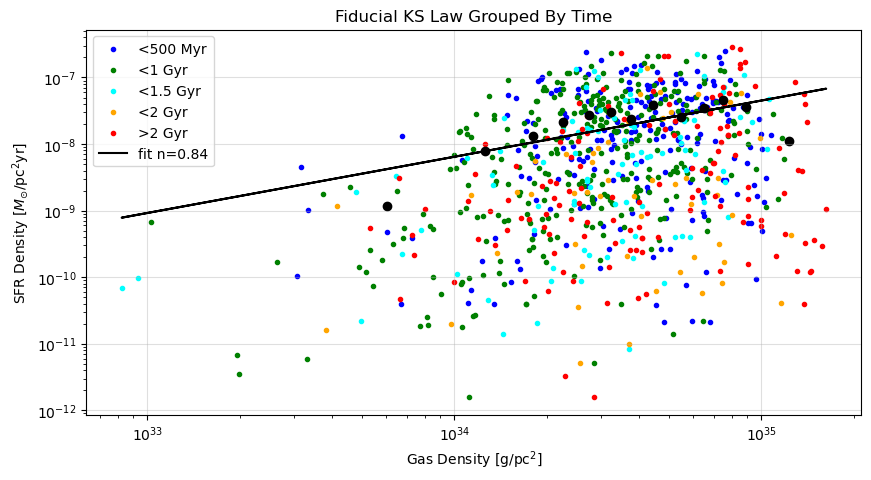

In [29]:
# plot it
plt.figure(figsize=(10,5))
plt.title('Fiducial KS Law Grouped By Time')
plt.scatter(fid_gas_lt500Myr, fid_SFR_lt500Myr, marker='.', color='blue', label='<500 Myr')
plt.scatter(fid_gas_lt1Gyr, fid_SFR_lt1Gyr, marker='.', color='green', label='<1 Gyr')
plt.scatter(fid_gas_lt1p5Gyr, fid_SFR_lt1p5Gyr, marker='.', color='cyan', label='<1.5 Gyr')
plt.scatter(fid_gas_lt2Gyr, fid_SFR_lt2Gyr, marker='.', color='orange', label='<2 Gyr')
plt.scatter(fid_gas_gt2Gyr, fid_SFR_gt2Gyr, marker='.', color='red', label='>2 Gyr')
plt.plot(fid_gas, power_law(fid_gas, A, b), color='black', label=f'fit n={b:.2f}')

plt.scatter(fid_gas_averages, fid_SFR_averages, color='black')

plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'SFR Density [$M_{\odot}$/pc$^2$yr]')
plt.xlabel(r'Gas Density [g/pc$^2$]')
plt.grid(alpha=0.4)
plt.legend()

## This section would plot different time groupings of the fiducial sim and fit individual lines to them

In [ ]:
plt.figure(figsize=(10,10))
plt.suptitle('Fiducial Different KS Fits Over Time')

plt.subplot(2,2,1)
plt.title('500 Myr')
plt.scatter(fid_gas[fid_time==4.999904e-01], fid_SFR[fid_time==4.999904e-01], label='data')
plt.plot(fid_gas[fid_time==4.999904e-01], power_law(fid_gas[fid_time==4.999904e-01], fid_A[7], fid_b[7]), 
         color='red', label=f'Fit: y = {fid_A[7]:.2e} * x^{fid_b[7]:.2f}')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'SFR Density [$M_{\odot}$/pc$^2$yr]')
plt.xlabel(r'Gas Density [g/pc$^2$]')
plt.grid(alpha=0.4)
plt.legend()




plt.subplot(2,2,2)
plt.title('1 Gyr')
plt.scatter(fid_gas[fid_time==9.999808e-01], fid_SFR[fid_time==9.999808e-01], label='data')
plt.plot(fid_gas[fid_time==9.999808e-01], power_law(fid_gas[fid_time==9.999808e-01], fid_A[17], fid_b[17]), 
         color='red', label=f'Fit: y = {fid_A[17]:.2e} * x^{fid_b[17]:.2f}')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'SFR Density [$M_{\odot}$/pc$^2$yr]')
plt.xlabel(r'Gas Density [g/pc$^2$]')
plt.grid(alpha=0.4)
plt.legend()




plt.subplot(2,2,3)
plt.title('1.5 Gyr')
plt.scatter(fid_gas[fid_time==1.499971e+00], fid_SFR[fid_time==1.499971e+00], label='data')
plt.plot(fid_gas[fid_time==1.499971e+00], power_law(fid_gas[fid_time==1.499971e+00], fid_A[27], fid_b[27]), 
         color='red', label=f'Fit: y = {fid_A[27]:.2e} * x^{fid_b[27]:.2f}')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'SFR Density [$M_{\odot}$/pc$^2$yr]')
plt.xlabel(r'Gas Density [g/pc$^2$]')
plt.grid(alpha=0.4)
plt.legend()




plt.subplot(2,2,4)
plt.title('2 Gyr')
plt.scatter(fid_gas[fid_time==1.999962e+00], fid_SFR[fid_time==1.999962e+00], label='data')
plt.plot(fid_gas[fid_time==1.999962e+00], power_law(fid_gas[fid_time==1.999962e+00], fid_A[36], fid_b[36]), 
         color='red', label=f'Fit: y = {fid_A[36]:.2e} * x^{fid_b[36]:.2f}')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'SFR Density [$M_{\odot}$/pc$^2$yr]')
plt.xlabel(r'Gas Density [g/pc$^2$]')
plt.grid(alpha=0.4)
plt.legend()

plt.tight_layout()

## This section is plotting the change in the b parameter of the power law fit. If follows the KS law, should be around 1.5

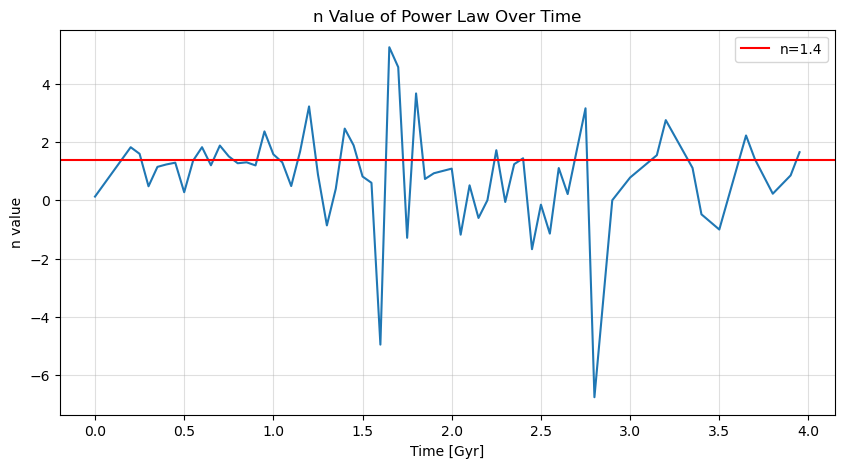

In [7]:
plt.figure(figsize=(10,5))
plt.plot(fid_param_time, fid_b)
plt.axhline(y=1.4, color='red', label='n=1.4')
plt.grid(alpha=0.4)
plt.xlabel('Time [Gyr]')
plt.ylabel('n value')
plt.title('n Value of Power Law Over Time')
plt.legend()

## This section is doing the same with the other three simulations

In [30]:
# load in the data for the other sims
h2sf_time, h2sf_gas, h2sf_SFR = np.loadtxt('./txt_files/h2sf_KS_SFR_and_density_data.txt', delimiter=',', unpack=True, skiprows=2)
h2sf_param_time, h2sf_A, h2sf_b = np.loadtxt('./txt_files/h2sf_KS_params_data.txt', delimiter=',', unpack=True, skiprows=1)

lowFB_time, lowFB_gas, lowFB_SFR = np.loadtxt('./txt_files/lowFB_KS_SFR_and_density_data.txt', delimiter=',', unpack=True, skiprows=2)
lowFB_param_time, lowFB_A, lowFB_b = np.loadtxt('./txt_files/lowFB_KS_params_data.txt', delimiter=',', unpack=True, skiprows=1)

newCGM_time, newCGM_gas, newCGM_SFR = np.loadtxt('/mnt/home/hodgso24/ScratchCopies/newCGM_h2sf/newCGM_KS_SFR_and_density_data.txt', delimiter=',', unpack=True, skiprows=2)
newCGM_param_time, newCGM_A, newCGM_b = np.loadtxt('/mnt/home/hodgso24/ScratchCopies/newCGM_h2sf/newCGM_KS_params_data.txt', delimiter=',', unpack=True, skiprows=1)

In [31]:
# mask data for time groups
h2sf_gas_lt500Myr = h2sf_gas[h2sf_time<=0.5]
h2sf_SFR_lt500Myr = h2sf_SFR[h2sf_time<=0.5]

h2sf_gas_lt1Gyr = h2sf_gas[(h2sf_time>0.5) & (h2sf_time<=1)]
h2sf_SFR_lt1Gyr = h2sf_SFR[(h2sf_time>0.5) & (h2sf_time<=1)]

h2sf_gas_lt1p5Gyr = h2sf_gas[(h2sf_time>1) & (h2sf_time<=1.5)]
h2sf_SFR_lt1p5Gyr = h2sf_SFR[(h2sf_time>1) & (h2sf_time<=1.5)]

h2sf_gas_lt2Gyr = h2sf_gas[(h2sf_time>1.5) & (h2sf_time<=2)]
h2sf_SFR_lt2Gyr = h2sf_SFR[(h2sf_time>1.5) & (h2sf_time<=2)]

h2sf_gas_gt2Gyr = h2sf_gas[h2sf_time>2]
h2sf_SFR_gt2Gyr = h2sf_SFR[h2sf_time>2]




lowFB_gas_lt500Myr = lowFB_gas[lowFB_time<=0.5]
lowFB_SFR_lt500Myr = lowFB_SFR[lowFB_time<=0.5]

lowFB_gas_lt1Gyr = lowFB_gas[(lowFB_time>0.5) & (lowFB_time<=1)]
lowFB_SFR_lt1Gyr = lowFB_SFR[(lowFB_time>0.5) & (lowFB_time<=1)]

lowFB_gas_lt1p5Gyr = lowFB_gas[(lowFB_time>1) & (lowFB_time<=1.5)]
lowFB_SFR_lt1p5Gyr = lowFB_SFR[(lowFB_time>1) & (lowFB_time<=1.5)]

lowFB_gas_lt2Gyr = lowFB_gas[(lowFB_time>1.5) & (lowFB_time<=2)]
lowFB_SFR_lt2Gyr = lowFB_SFR[(lowFB_time>1.5) & (lowFB_time<=2)]

lowFB_gas_gt2Gyr = lowFB_gas[lowFB_time>2]
lowFB_SFR_gt2Gyr = lowFB_SFR[lowFB_time>2]




newCGM_gas_lt500Myr = newCGM_gas[newCGM_time<=0.5]
newCGM_SFR_lt500Myr = newCGM_SFR[newCGM_time<=0.5]

newCGM_gas_lt1Gyr = newCGM_gas[(newCGM_time>0.5) & (newCGM_time<=1)]
newCGM_SFR_lt1Gyr = newCGM_SFR[(newCGM_time>0.5) & (newCGM_time<=1)]

newCGM_gas_lt1p5Gyr = newCGM_gas[(newCGM_time>1) & (newCGM_time<=1.5)]
newCGM_SFR_lt1p5Gyr = newCGM_SFR[(newCGM_time>1) & (newCGM_time<=1.5)]

newCGM_gas_lt2Gyr = newCGM_gas[(newCGM_time>1.5) & (newCGM_time<=2)]
newCGM_SFR_lt2Gyr = newCGM_SFR[(newCGM_time>1.5) & (newCGM_time<=2)]

newCGM_gas_gt2Gyr = newCGM_gas[newCGM_time>2]
newCGM_SFR_gt2Gyr = newCGM_SFR[newCGM_time>2]

In [40]:
# Generate bins
bins = np.array([1e32,5e32,1e33,3e33,1e34,5e34,1e35])

# Create a list of bins for fid_gas
h2sf_gas_bins = []
h2sf_SFR_bins = []

for i in range(len(bins) - 1):
    h2sf_gas_bins.append(h2sf_gas[(h2sf_gas >= bins[i]) & (h2sf_gas < bins[i + 1])])
    h2sf_SFR_bins.append(h2sf_SFR[(h2sf_gas >= bins[i]) & (h2sf_gas < bins[i + 1])])

# Handling the upper edge case for the last bin
h2sf_gas_bins[-1] = h2sf_gas[(h2sf_gas >= bins[-2]) & (h2sf_gas <= bins[-1])]
h2sf_SFR_bins[-1] = h2sf_SFR[(h2sf_gas >= bins[-2]) & (h2sf_gas <= bins[-1])]

# Print the bin edges and number of points in each bin
for i in range(len(bins) - 1):
    print(f"Bin {i+1}: {bins[i]} to {bins[i+1]}")
    print(f"Number of points in h2sf_gas_bin_{i+1}: {len(h2sf_gas_bins[i])}")
    print(f"Number of points in h2sf_SFR_bin_{i+1}: {len(h2sf_SFR_bins[i])}")

Bin 1: 1e+32 to 5e+32
Number of points in h2sf_gas_bin_1: 495
Number of points in h2sf_SFR_bin_1: 495
Bin 2: 5e+32 to 1e+33
Number of points in h2sf_gas_bin_2: 1970
Number of points in h2sf_SFR_bin_2: 1970
Bin 3: 1e+33 to 3e+33
Number of points in h2sf_gas_bin_3: 4001
Number of points in h2sf_SFR_bin_3: 4001
Bin 4: 3e+33 to 1e+34
Number of points in h2sf_gas_bin_4: 1235
Number of points in h2sf_SFR_bin_4: 1235
Bin 5: 1e+34 to 5e+34
Number of points in h2sf_gas_bin_5: 324
Number of points in h2sf_SFR_bin_5: 324
Bin 6: 5e+34 to 1e+35
Number of points in h2sf_gas_bin_6: 22
Number of points in h2sf_SFR_bin_6: 22


In [41]:
h2sf_gas_averages= []
h2sf_SFR_averages = []

for val in h2sf_gas_bins:
    average = np.mean(val)
    h2sf_gas_averages.append(average)
    
for val in h2sf_SFR_bins:
    average = np.mean(val)
    h2sf_SFR_averages.append(average)
    
# Log-transform the data
log_dens = np.log(h2sf_gas_averages)
log_SFR = np.log(h2sf_SFR_averages)

# Add a constant to the log density (intercept term)
log_dens = sm.add_constant(log_dens)

# Fit the model
model = sm.OLS(log_SFR, log_dens).fit()

# Extract the parameters
A = np.exp(model.params[0])
b = model.params[1]

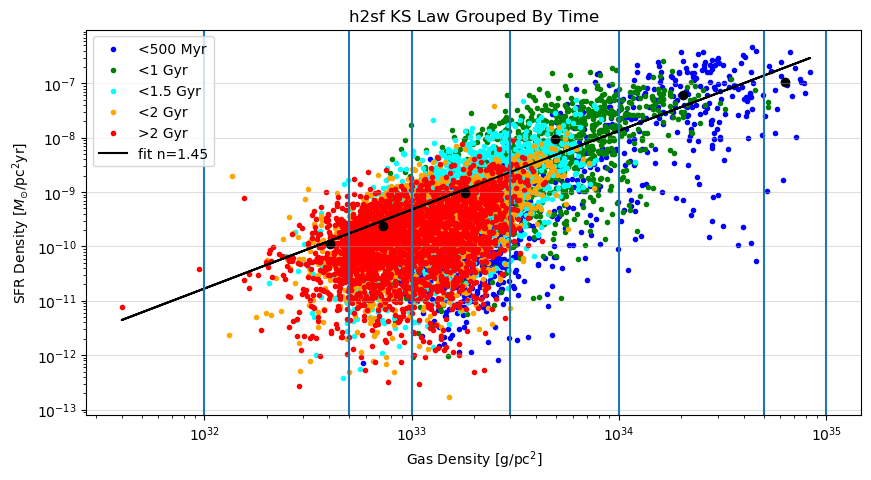

In [42]:
plt.figure(figsize=(10,5))
plt.title('h2sf KS Law Grouped By Time')
plt.scatter(h2sf_gas_lt500Myr, h2sf_SFR_lt500Myr, marker='.', color='blue', label='<500 Myr')
plt.scatter(h2sf_gas_lt1Gyr, h2sf_SFR_lt1Gyr, marker='.', color='green', label='<1 Gyr')
plt.scatter(h2sf_gas_lt1p5Gyr, h2sf_SFR_lt1p5Gyr, marker='.', color='cyan', label='<1.5 Gyr')
plt.scatter(h2sf_gas_lt2Gyr, h2sf_SFR_lt2Gyr, marker='.', color='orange', label='<2 Gyr')
plt.scatter(h2sf_gas_gt2Gyr, h2sf_SFR_gt2Gyr, marker='.', color='red', label='>2 Gyr')
plt.plot(h2sf_gas, power_law(h2sf_gas, A, b), color='black', label=f'fit n={b:.2f}')

plt.scatter(h2sf_gas_averages, h2sf_SFR_averages, color='black')

plt.axvline(x=bins[0])
plt.axvline(x=bins[1])
plt.axvline(x=bins[2])
plt.axvline(x=bins[3])
plt.axvline(x=bins[4])
plt.axvline(x=bins[5])
plt.axvline(x=bins[6])

plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'SFR Density [$M_{\odot}$/pc$^2$yr]')
plt.xlabel(r'Gas Density [g/pc$^2$]')
plt.grid(alpha=0.4)
plt.legend()

In [ ]:
# Generate bins
bins = np.array([1e32,5e32,1e33,3e33,1e34,5e34,1e35])

# Create a list of bins for fid_gas
lowFB_gas_bins = []
lowFB_SFR_bins = []

for i in range(len(bins) - 1):
    lowFB_gas_bins.append(lowFB_gas[(lowFB_gas >= bins[i]) & (lowFB_gas < bins[i + 1])])
    lowFB_SFR_bins.append(lowFB_SFR[(h2sf_gas >= bins[i]) & (lowFB_gas < bins[i + 1])])

# Handling the upper edge case for the last bin
lowFB_gas_bins[-1] = lowFB_gas[(lowFB_gas >= bins[-2]) & (lowFB_gas <= bins[-1])]
lowFB_SFR_bins[-1] = lowFB_SFR[(lowFB_gas >= bins[-2]) & (lowFB_gas <= bins[-1])]

# Print the bin edges and number of points in each bin
for i in range(len(bins) - 1):
    print(f"Bin {i+1}: {bins[i]} to {bins[i+1]}")
    print(f"Number of points in h2sf_gas_bin_{i+1}: {len(h2sf_gas_bins[i])}")
    print(f"Number of points in h2sf_SFR_bin_{i+1}: {len(h2sf_SFR_bins[i])}")

In [ ]:
h2sf_gas_averages= []
h2sf_SFR_averages = []

for val in h2sf_gas_bins:
    average = np.mean(val)
    h2sf_gas_averages.append(average)
    
for val in h2sf_SFR_bins:
    average = np.mean(val)
    h2sf_SFR_averages.append(average)
    
# Log-transform the data
log_dens = np.log(h2sf_gas_averages)
log_SFR = np.log(h2sf_SFR_averages)

# Add a constant to the log density (intercept term)
log_dens = sm.add_constant(log_dens)

# Fit the model
model = sm.OLS(log_SFR, log_dens).fit()

# Extract the parameters
A = np.exp(model.params[0])
b = model.params[1]

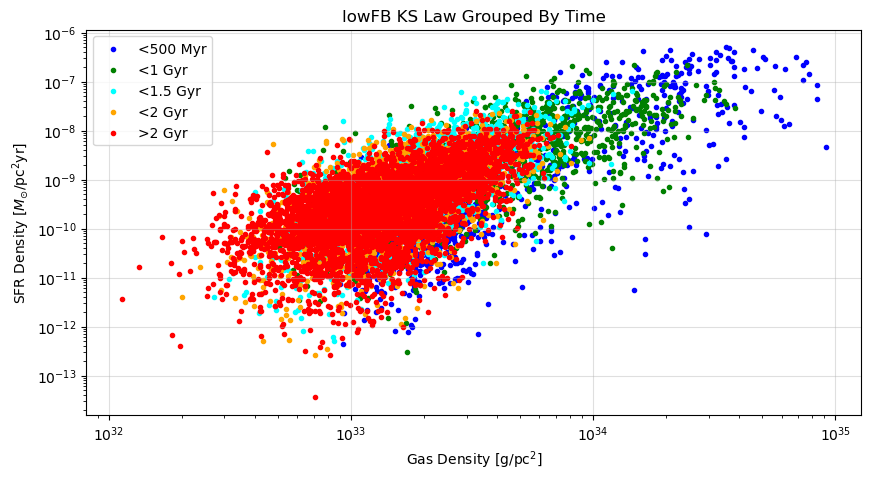

In [11]:
plt.figure(figsize=(10,5))
plt.title('lowFB KS Law Grouped By Time')
plt.scatter(lowFB_gas_lt500Myr, lowFB_SFR_lt500Myr, marker='.', color='blue', label='<500 Myr')
plt.scatter(lowFB_gas_lt1Gyr, lowFB_SFR_lt1Gyr, marker='.', color='green', label='<1 Gyr')
plt.scatter(lowFB_gas_lt1p5Gyr, lowFB_SFR_lt1p5Gyr, marker='.', color='cyan', label='<1.5 Gyr')
plt.scatter(lowFB_gas_lt2Gyr, lowFB_SFR_lt2Gyr, marker='.', color='orange', label='<2 Gyr')
plt.scatter(lowFB_gas_gt2Gyr, lowFB_SFR_gt2Gyr, marker='.', color='red', label='>2 Gyr')
plt.plot(h2sf_gas, power_law(h2sf_gas, A, b), color='black', label=f'fit n={b:.2f}')

plt.scatter(h2sf_gas_averages, h2sf_SFR_averages, color='black')

plt.axvline(x=bins[0])
plt.axvline(x=bins[1])
plt.axvline(x=bins[2])
plt.axvline(x=bins[3])
plt.axvline(x=bins[4])
plt.axvline(x=bins[5])
plt.axvline(x=bins[6])


plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'SFR Density [$M_{\odot}$/pc$^2$yr]')
plt.xlabel(r'Gas Density [g/pc$^2$]')
plt.grid(alpha=0.4)
plt.legend()

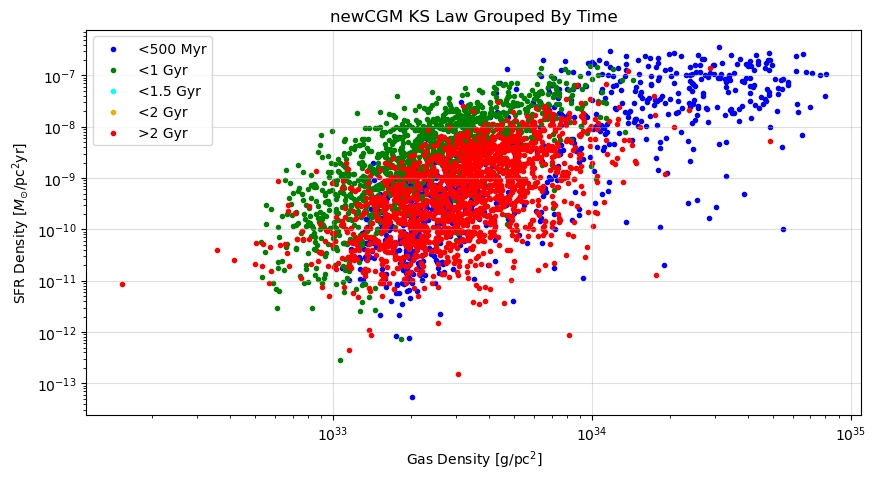

In [12]:
plt.figure(figsize=(10,5))
plt.title('newCGM KS Law Grouped By Time')
plt.scatter(newCGM_gas_lt500Myr, newCGM_SFR_lt500Myr, marker='.', color='blue', label='<500 Myr')
plt.scatter(newCGM_gas_lt1Gyr, newCGM_SFR_lt1Gyr, marker='.', color='green', label='<1 Gyr')
plt.scatter(newCGM_gas_lt1p5Gyr, newCGM_SFR_lt1p5Gyr, marker='.', color='cyan', label='<1.5 Gyr')
plt.scatter(newCGM_gas_lt2Gyr, newCGM_SFR_lt2Gyr, marker='.', color='orange', label='<2 Gyr')
plt.scatter(newCGM_gas_gt2Gyr, newCGM_SFR_gt2Gyr, marker='.', color='red', label='>2 Gyr')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'SFR Density [$M_{\odot}$/pc$^2$yr]')
plt.xlabel(r'Gas Density [g/pc$^2$]')
plt.grid(alpha=0.4)
plt.legend()

## This section would plot the b value of the power law fit over time. If it follows the KS law the n value should be around 1.3-4.

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(h2sf_param_time, h2sf_b)
plt.axhline(y=1.4, color='red', label='n=1.4')
plt.grid(alpha=0.4)
plt.xlabel('Time [Gyr]')
plt.ylabel('n value')
plt.title('h2sf n Value of Power Law Over Time')
plt.legend()

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(lowFB_param_time, lowFB_b)
plt.axhline(y=1.4, color='red', label='n=1.4')
plt.grid(alpha=0.4)
plt.xlabel('Time [Gyr]')
plt.ylabel('n value')
plt.title('lowFB n Value of Power Law Over Time')
plt.legend()

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(newCGM_param_time, newCGM_b)
plt.axhline(y=1.4, color='red', label='n=1.4')
plt.grid(alpha=0.4)
plt.xlabel('Time [Gyr]')
plt.ylabel('n value')
plt.title('newCGM n Value of Power Law Over Time')
plt.legend()